In [1]:
# Данные тут
# https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime

#pip install tscv
import tscv

from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error

## Работаем с "чистыми данными"

Удалим дубли остально оставим

In [2]:
## Время должно быть переведено в "удобный" формат
## Внимание astype теперь не работает

df = df = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv',
                 index_col='Date',
                 parse_dates = True, date_format='mixed').sort_index()
df = df[~df.index.duplicated(keep='last')]
df = df.dropna()
df = df.drop(['Fremont Bridge East Sidewalk','Fremont Bridge West Sidewalk'],axis=1)

dfb = df['2019-07':'2019-09']

In [3]:
X_t = dfb.index.view(int)// 10**10
X = X_t.reshape(-1,1)
y = dfb['Fremont Bridge Total'].values

gap_size = 3*24
cv = tscv.GapKFold(n_splits=5, gap_before= 24*3, gap_after=24*3)
X_train, X_test, y_train, y_test = tscv.gap_train_test_split(
                X, y, 
                test_size = 0.25, 
                gap_size=gap_size)

In [4]:
dfb.index.view(int)

array([1561939200000000000, 1561942800000000000, 1561946400000000000, ...,
       1569877200000000000, 1569880800000000000, 1569884400000000000])

In [5]:
X

array([[156193920],
       [156194280],
       [156194640],
       ...,
       [156987720],
       [156988080],
       [156988440]])

In [6]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
scores = cross_val_score(regressor, X_train, y_train, cv=cv)

print("R^2 тренировок:  ", scores)
print("средний R^2 тренировок:  ", scores.mean())

R^2 тренировок:   [-0.36101895 -2.61220186 -3.26343247 -0.35930816 -2.3632802 ]
средний R^2 тренировок:   -1.7918483254655115


In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

regressor.fit(X_train, y_train)
y_train_predict = regressor.predict(X_train)
y_predict = regressor.predict(X_test)

print("R^2 :  ", r2_score(y_test, y_predict))
print("RMSE :  ", root_mean_squared_error(y_test, y_predict)) 

R^2 :   -9.624392921371403
RMSE :   631.7834207614693


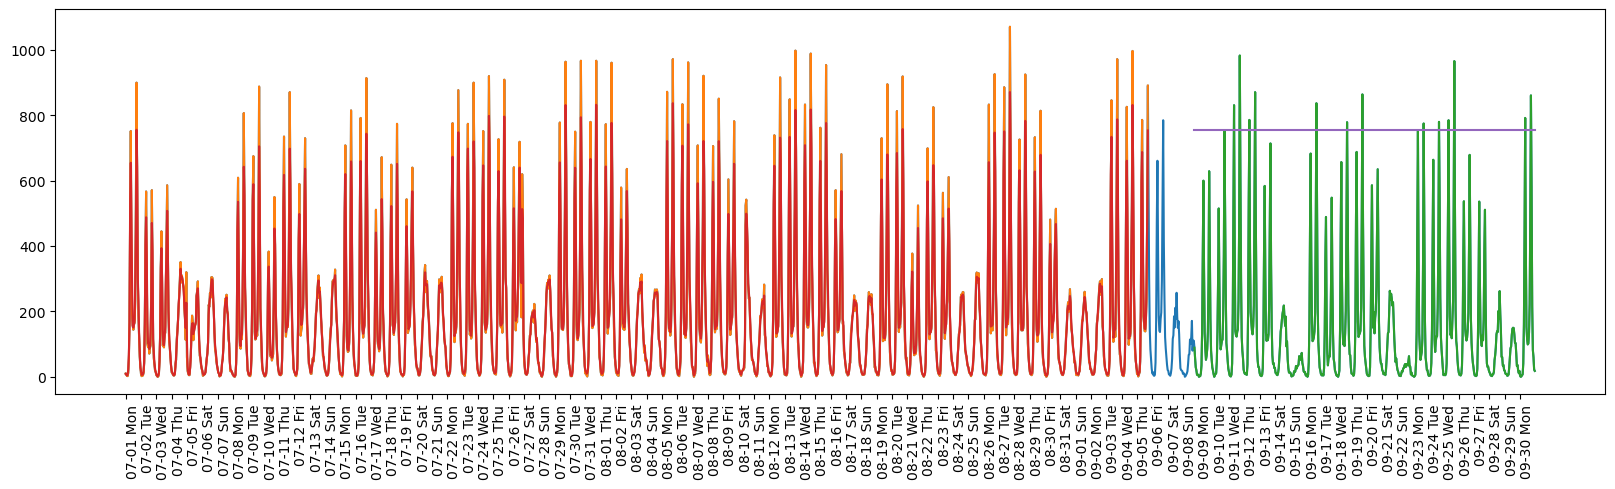

In [8]:
plt.figure(figsize=(20, 5))

### исходные данные

xticks = pd.date_range(start = dfb.index.min(), end=dfb.index.max(),freq='D')
x_range = [dfb.index.get_loc(t) for t in xticks]

plt.xticks(x_range, xticks.strftime("%m-%d %a"), rotation=90, ha="left")

# все истина
plt.plot(range(len(X)), y, label="all")
# тренировка истина
plt.plot(range(len(X_train)), y_train, label="train")
# тест истина
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_test, label="train");

# тренировка predict
plt.plot(range(len(X_train)), y_train_predict, label="train predict")

# тренировка predict
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_predict, label="predict");